# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import nltk
import gc
import pyLDAvis.sklearn
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet 
import string
%matplotlib inline

pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

In [3]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Read Data

In [4]:
df=pd.read_csv('./tinder_google_play_reviews.csv')

In [5]:
df.head(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOE_kDnGh_ep3YzP9lvT1EXNZn149NKBZS6O7wbYF79d2gPcpDPoSYZcqMQJTsReBefzWA1YvMiyTfdqO9I,James Davis,https://play-lh.googleusercontent.com/a-/AOh14GhCKkdKAOzTfsUaXbh6OQ8TSzIpha0ZdDP5yFBF,Love it,5,0,13.4.0,2022-03-26 22:34:58,NaN,NaN
1,gp:AOqpTOEsFX7k4uvzb9nMFhm3_F_fi8jO4XJRTDXaVTTwOuIPORaBOV5FD5vFawtgDNn0JYLkECTjKymG58YRp80,Alex D,https://play-lh.googleusercontent.com/a/AATXAJwWCqtvQl5oXnmef_YcxWBmFbcArernRxvIfDxuiw=mo,"Very greedy app. I bought Tinder Platinum, but anyway have to pay a lot of other options",1,0,13.4.0,2022-03-26 22:31:32,NaN,NaN
2,gp:AOqpTOFrbe5VHxNYs2DiAiQSBE1iRudXd0z1vB9U77TMObQM8drXxR0OHfzw0KzR1QZtB2Yo6GQQ48F-TZO7xtw,Emil Laukkanen,https://play-lh.googleusercontent.com/a-/AOh14Giq0fS5ZzqzG0QLM2MPR5aMSLUrXpMhpZk6qhQoGQ,"Met my girlfriend here, so gotta rate it 5/5",5,0,NaN,2022-03-26 22:06:54,NaN,NaN
3,gp:AOqpTOFlSy_0E2l-R9A3ncMJF2RVTNgfk6i818PufiGIFlU-iaVmGeoLNinx6wvr9KJCua7PCXqP8iVputMi7YM,Humphrey Little,https://play-lh.googleusercontent.com/a/AATXAJwaWDms44vgvf9Kryr0B_aiUbEpf1dI7RETz6hb=mo,Adding profile pictures. Useless. How are they sorted? Can't find any personal photos taken. Use...,1,1,13.4.0,2022-03-26 21:59:56,NaN,NaN
4,gp:AOqpTOHc7vZRC2k4YEsHxfGNZsEWRieGIboc5CILynvWjW40MBMsMkH_ulDzr6PyrTRXNXHC_suZ_QZMj8aTqqQ,Abdelhay Amazdar,https://play-lh.googleusercontent.com/a/AATXAJxDb7xkW9_KZ7WFe1xLtaTgj_jAVegyswZySP-X=mo,"Its not working, im trying to sing up for tow days but nothhng work, sorry but that is the truth",1,0,NaN,2022-03-26 21:45:59,NaN,NaN


# Data Description

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531174 entries, 0 to 531173
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              531174 non-null  object
 1   userName              531169 non-null  object
 2   userImage             531174 non-null  object
 3   content               529829 non-null  object
 4   score                 531174 non-null  int64 
 5   thumbsUpCount         531174 non-null  int64 
 6   reviewCreatedVersion  423986 non-null  object
 7   at                    531174 non-null  object
 8   replyContent          47699 non-null   object
 9   repliedAt             47699 non-null   object
dtypes: int64(2), object(8)
memory usage: 40.5+ MB


# Feature Identification

In [7]:
df.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt'],
      dtype='object')

# Numeric Data

In [10]:
numeric=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num=df.select_dtypes(include=numeric)
df_num.columns

Index(['score', 'thumbsUpCount'], dtype='object')

# Data categorical

In [11]:
df_cat=df.select_dtypes(include='object')
df_cat.head(3)

,reviewId,userName,userImage,content,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOE_kDnGh_ep3YzP9lvT1EXNZn149NKBZS6O7wbYF79d2gPcpDPoSYZcqMQJTsReBefzWA1YvMiyTfdqO9I,James Davis,https://play-lh.googleusercontent.com/a-/AOh14GhCKkdKAOzTfsUaXbh6OQ8TSzIpha0ZdDP5yFBF,Love it,13.4.0,2022-03-26 22:34:58,NaN,NaN
1,gp:AOqpTOEsFX7k4uvzb9nMFhm3_F_fi8jO4XJRTDXaVTTwOuIPORaBOV5FD5vFawtgDNn0JYLkECTjKymG58YRp80,Alex D,https://play-lh.googleusercontent.com/a/AATXAJwWCqtvQl5oXnmef_YcxWBmFbcArernRxvIfDxuiw=mo,"Very greedy app. I bought Tinder Platinum, but anyway have to pay a lot of other options",13.4.0,2022-03-26 22:31:32,NaN,NaN
2,gp:AOqpTOFrbe5VHxNYs2DiAiQSBE1iRudXd0z1vB9U77TMObQM8drXxR0OHfzw0KzR1QZtB2Yo6GQQ48F-TZO7xtw,Emil Laukkanen,https://play-lh.googleusercontent.com/a-/AOh14Giq0fS5ZzqzG0QLM2MPR5aMSLUrXpMhpZk6qhQoGQ,"Met my girlfriend here, so gotta rate it 5/5",NaN,2022-03-26 22:06:54,NaN,NaN


# Missing Value

In [12]:
null=pd.DataFrame(df.isnull().sum(),columns=["Null Values"])
null["% Missing Values"]=(df.isna().sum()/len(df)*100)
null = null[null["% Missing Values"] > 0]
null.style.background_gradient(cmap='viridis',low =0.2,high=0.1) 

,Null Values,% Missing Values
userName,5,0.000941
content,1345,0.253213
reviewCreatedVersion,107188,20.179452
replyContent,483475,91.020080
repliedAt,483475,91.020080


## Reason
For our analysis content is the only useful component while other won't be a useful information.

In [13]:
df.dropna(subset=['content'], inplace=True)

In [14]:
df.drop(['userName', 'reviewCreatedVersion', 'replyContent', 'repliedAt'], axis=1, inplace=True)

In [15]:
null=pd.DataFrame(df.isnull().sum(),columns=["Null Values"])
null["% Missing Values"]=(df.isna().sum()/len(df)*100)
null = null[null["% Missing Values"] > 0]
null.style.background_gradient(cmap='viridis',low =0.2,high=0.1) 

,Null Values,% Missing Values


# Numerical Analysis

In [16]:
describeNum = df.describe(include =['float64', 'int64', 'float', 'int'])
describeNum.T.style.background_gradient(cmap='viridis',low=0.2,high=0.1)

,count,mean,std,min,25%,50%,75%,max
score,529829.000000,3.002835,1.758325,0.000000,1.000000,3.000000,5.000000,5.000000
thumbsUpCount,529829.000000,1.730081,26.413986,0.000000,0.000000,0.000000,0.000000,5506.000000


In [17]:
describeNumCat = df.describe(include=["O"])
describeNumCat.T.style.background_gradient(cmap='viridis',low=0.2,high=0.1)

,count,unique,top,freq
reviewId,529829,529829,gp:AOqpTOE_kDnGh_ep3YzP9lvT1EXNZn149NKBZS6O7wbYF79d2gPcpDPoSYZcqMQJTsReBefzWA1YvMiyTfdqO9I,1
userImage,529829,493506,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,36324
content,529829,393956,Good,12188
at,529829,529004,2021-02-04 23:16:24,4


# Correlation

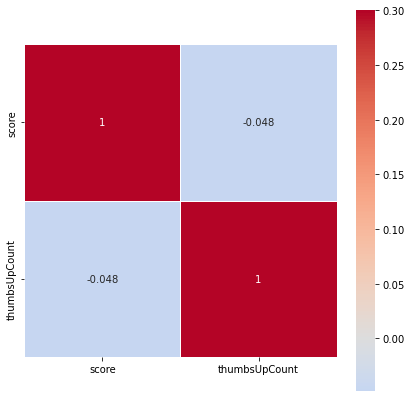

In [20]:
plt.figure(figsize=(7, 7))
sns.heatmap(df.corr(),  cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5,annot=True)
plt.show()

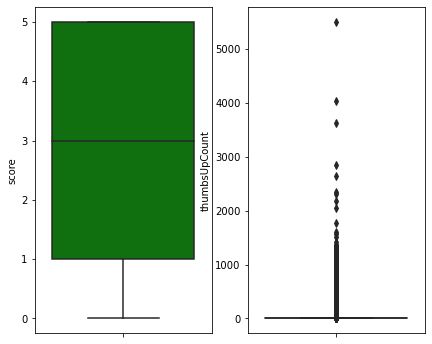

In [22]:
numeric=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num=df.select_dtypes(include=numeric)
df_num.columns
featuresNum = df_num.columns

plt.figure(figsize=(7,6))
for i in range(0, len(featuresNum)):
    plt.subplot(1, len(featuresNum), i+1)
    sns.boxplot(y=df[featuresNum[i]], color='green', orient='v')

# Tokenize

In [23]:
puntucations = ['.','!','(',')','-','[',']','{','}',',',',',';',':','"','<','>','/','?','@','#','$','%','^','&','*','_','~']

In [24]:
df['content_words'] = [word_tokenize(l.translate(str.maketrans('', '', string.punctuation))) for l in df['content']]
df.head()
df['content_sents'] = [sent_tokenize(l) for l in df['content']]
df.head()

,reviewId,userImage,content,score,thumbsUpCount,at,content_words,content_sents
0,gp:AOqpTOE_kDnGh_ep3YzP9lvT1EXNZn149NKBZS6O7wbYF79d2gPcpDPoSYZcqMQJTsReBefzWA1YvMiyTfdqO9I,https://play-lh.googleusercontent.com/a-/AOh14GhCKkdKAOzTfsUaXbh6OQ8TSzIpha0ZdDP5yFBF,Love it,5,0,2022-03-26 22:34:58,"[Love, it]",[Love it]
1,gp:AOqpTOEsFX7k4uvzb9nMFhm3_F_fi8jO4XJRTDXaVTTwOuIPORaBOV5FD5vFawtgDNn0JYLkECTjKymG58YRp80,https://play-lh.googleusercontent.com/a/AATXAJwWCqtvQl5oXnmef_YcxWBmFbcArernRxvIfDxuiw=mo,"Very greedy app. I bought Tinder Platinum, but anyway have to pay a lot of other options",1,0,2022-03-26 22:31:32,"[Very, greedy, app, I, bought, Tinder, Platinum, but, anyway, have, to, pay, a, lot, of, other, ...","[Very greedy app., I bought Tinder Platinum, but anyway have to pay a lot of other options]"
2,gp:AOqpTOFrbe5VHxNYs2DiAiQSBE1iRudXd0z1vB9U77TMObQM8drXxR0OHfzw0KzR1QZtB2Yo6GQQ48F-TZO7xtw,https://play-lh.googleusercontent.com/a-/AOh14Giq0fS5ZzqzG0QLM2MPR5aMSLUrXpMhpZk6qhQoGQ,"Met my girlfriend here, so gotta rate it 5/5",5,0,2022-03-26 22:06:54,"[Met, my, girlfriend, here, so, got, ta, rate, it, 55]","[Met my girlfriend here, so gotta rate it 5/5]"
3,gp:AOqpTOFlSy_0E2l-R9A3ncMJF2RVTNgfk6i818PufiGIFlU-iaVmGeoLNinx6wvr9KJCua7PCXqP8iVputMi7YM,https://play-lh.googleusercontent.com/a/AATXAJwaWDms44vgvf9Kryr0B_aiUbEpf1dI7RETz6hb=mo,Adding profile pictures. Useless. How are they sorted? Can't find any personal photos taken. Use...,1,1,2022-03-26 21:59:56,"[Adding, profile, pictures, Useless, How, are, they, sorted, Cant, find, any, personal, photos, ...","[Adding profile pictures., Useless., How are they sorted?, Can't find any personal photos taken...."
4,gp:AOqpTOHc7vZRC2k4YEsHxfGNZsEWRieGIboc5CILynvWjW40MBMsMkH_ulDzr6PyrTRXNXHC_suZ_QZMj8aTqqQ,https://play-lh.googleusercontent.com/a/AATXAJxDb7xkW9_KZ7WFe1xLtaTgj_jAVegyswZySP-X=mo,"Its not working, im trying to sing up for tow days but nothhng work, sorry but that is the truth",1,0,2022-03-26 21:45:59,"[Its, not, working, im, trying, to, sing, up, for, tow, days, but, nothhng, work, sorry, but, th...","[Its not working, im trying to sing up for tow days but nothhng work, sorry but that is the truth]"


# Lemmatize and removal of stopwords

In [28]:
content_lemmatize = []
for l in df['content_words']:
    lemmatize_str = ''
    for word in l:
        lemmatize_str = lemmatize_str + ' ' + lemmatizer.lemmatize(word)
    content_lemmatize.append(lemmatize_str)
        
df['content_lemmatize'] = content_lemmatize

In [29]:
content_lemmatize_stopwords_remove = []
for l in df['content_words']:
    lemmatize_str = ''
    for word in l:
        if word in stop_words:
            continue
        lemmatize_str = lemmatize_str + ' ' + lemmatizer.lemmatize(word)
    content_lemmatize_stopwords_remove.append(lemmatize_str)
        
df['content_lemmatize_stopwords_remove'] = content_lemmatize_stopwords_remove

In [30]:
df.head(20)

,reviewId,userImage,content,score,thumbsUpCount,at,content_words,content_sents,content_lemmatize,content_lemmatize_stopwords_remove
0,gp:AOqpTOE_kDnGh_ep3YzP9lvT1EXNZn149NKBZS6O7wbYF79d2gPcpDPoSYZcqMQJTsReBefzWA1YvMiyTfdqO9I,https://play-lh.googleusercontent.com/a-/AOh14GhCKkdKAOzTfsUaXbh6OQ8TSzIpha0ZdDP5yFBF,Love it,5,0,2022-03-26 22:34:58,"[Love, it]",[Love it],Love it,Love
1,gp:AOqpTOEsFX7k4uvzb9nMFhm3_F_fi8jO4XJRTDXaVTTwOuIPORaBOV5FD5vFawtgDNn0JYLkECTjKymG58YRp80,https://play-lh.googleusercontent.com/a/AATXAJwWCqtvQl5oXnmef_YcxWBmFbcArernRxvIfDxuiw=mo,"Very greedy app. I bought Tinder Platinum, but anyway have to pay a lot of other options",1,0,2022-03-26 22:31:32,"[Very, greedy, app, I, bought, Tinder, Platinum, but, anyway, have, to, pay, a, lot, of, other, ...","[Very greedy app., I bought Tinder Platinum, but anyway have to pay a lot of other options]",Very greedy app I bought Tinder Platinum but anyway have to pay a lot of other option,Very greedy app I bought Tinder Platinum anyway pay lot option
2,gp:AOqpTOFrbe5VHxNYs2DiAiQSBE1iRudXd0z1vB9U77TMObQM8drXxR0OHfzw0KzR1QZtB2Yo6GQQ48F-TZO7xtw,https://play-lh.googleusercontent.com/a-/AOh14Giq0fS5ZzqzG0QLM2MPR5aMSLUrXpMhpZk6qhQoGQ,"Met my girlfriend here, so gotta rate it 5/5",5,0,2022-03-26 22:06:54,"[Met, my, girlfriend, here, so, got, ta, rate, it, 55]","[Met my girlfriend here, so gotta rate it 5/5]",Met my girlfriend here so got ta rate it 55,Met girlfriend got ta rate 55
3,gp:AOqpTOFlSy_0E2l-R9A3ncMJF2RVTNgfk6i818PufiGIFlU-iaVmGeoLNinx6wvr9KJCua7PCXqP8iVputMi7YM,https://play-lh.googleusercontent.com/a/AATXAJwaWDms44vgvf9Kryr0B_aiUbEpf1dI7RETz6hb=mo,Adding profile pictures. Useless. How are they sorted? Can't find any personal photos taken. Use...,1,1,2022-03-26 21:59:56,"[Adding, profile, pictures, Useless, How, are, they, sorted, Cant, find, any, personal, photos, ...","[Adding profile pictures., Useless., How are they sorted?, Can't find any personal photos taken....",Adding profile picture Useless How are they sorted Cant find any personal photo taken Useless,Adding profile picture Useless How sorted Cant find personal photo taken Useless
4,gp:AOqpTOHc7vZRC2k4YEsHxfGNZsEWRieGIboc5CILynvWjW40MBMsMkH_ulDzr6PyrTRXNXHC_suZ_QZMj8aTqqQ,https://play-lh.googleusercontent.com/a/AATXAJxDb7xkW9_KZ7WFe1xLtaTgj_jAVegyswZySP-X=mo,"Its not working, im trying to sing up for tow days but nothhng work, sorry but that is the truth",1,0,2022-03-26 21:45:59,"[Its, not, working, im, trying, to, sing, up, for, tow, days, but, nothhng, work, sorry, but, th...","[Its not working, im trying to sing up for tow days but nothhng work, sorry but that is the truth]",Its not working im trying to sing up for tow day but nothhng work sorry but that is the truth,Its working im trying sing tow day nothhng work sorry truth
5,gp:AOqpTOFcrOWVoK_Gh7BN60CONoj2nmdhiFr0kyocXJFkyEndO7moITfOhuXWmRYrvwG2uY3iFyP7HRd3EWHuB5g,https://play-lh.googleusercontent.com/a-/AOh14GjDfbNREYo0AYVE5y1rfC-IC4JDdQKzivk5O2gmjg,OMG remove the superlike button,4,0,2022-03-26 21:44:11,"[OMG, remove, the, superlike, button]",[OMG remove the superlike button],OMG remove the superlike button,OMG remove superlike button
6,gp:AOqpTOHb-AjRwWfM0Np-yuOd1slLaWky8brV0NajhUW5Mo08XPh8RSP2j40nz2NeJNZJOlrPiLMzwlTBKHpSlUk,https://play-lh.googleusercontent.com/a/AATXAJwlttuVh2lYAQaMDuIFgiMfo2DX9JIgw_PJSv7b=mo,Excellent,5,0,2022-03-26 21:37:21,[Excellent],[Excellent],Excellent,Excellent
7,gp:AOqpTOGavjX7PobTKlGmQ-eHndCfYeQp_ObCrme4F0H-pG_6YkusQf1c2JCfpfRKmWVW0UxWRqnDIlpT6I4D5aw,https://play-lh.googleusercontent.com/a-/AOh14GgIqN3Fs6huc9WXryqZJLwpZIMKxg59dR_iz3g_,and now this horrible service even doesn't allow you to delete your account,1,0,2022-03-26 21:35:48,"[and, now, this, horrible, service, even, doesnt, allow, you, to, delete, your, account]",[and now this horrible service even doesn't allow you to delete your account],and now this horrible service even doesnt allow you to delete your account,horrible service even doesnt allow delete accoun

# Sentiment

## Sentiment Analysis with stopwords

In [31]:
df['sentiment_stopwords'] = df['content_lemmatize'].apply(lambda x: TextBlob(x).sentiment.polarity)
df.head()

,reviewId,userImage,content,score,thumbsUpCount,at,content_words,content_sents,content_lemmatize,content_lemmatize_stopwords_remove,sentiment_stopwords
0,gp:AOqpTOE_kDnGh_ep3YzP9lvT1EXNZn149NKBZS6O7wbYF79d2gPcpDPoSYZcqMQJTsReBefzWA1YvMiyTfdqO9I,https://play-lh.googleusercontent.com/a-/AOh14GhCKkdKAOzTfsUaXbh6OQ8TSzIpha0ZdDP5yFBF,Love it,5,0,2022-03-26 22:34:58,"[Love, it]",[Love it],Love it,Love,0.500000
1,gp:AOqpTOEsFX7k4uvzb9nMFhm3_F_fi8jO4XJRTDXaVTTwOuIPORaBOV5FD5vFawtgDNn0JYLkECTjKymG58YRp80,https://play-lh.googleusercontent.com/a/AATXAJwWCqtvQl5oXnmef_YcxWBmFbcArernRxvIfDxuiw=mo,"Very greedy app. I bought Tinder Platinum, but anyway have to pay a lot of other options",1,0,2022-03-26 22:31:32,"[Very, greedy, app, I, bought, Tinder, Platinum, but, anyway, have, to, pay, a, lot, of, other, ...","[Very greedy app., I bought Tinder Platinum, but anyway have to pay a lot of other options]",Very greedy app I bought Tinder Platinum but anyway have to pay a lot of other option,Very greedy app I bought Tinder Platinum anyway pay lot option,0.037500
2,gp:AOqpTOFrbe5VHxNYs2DiAiQSBE1iRudXd0z1vB9U77TMObQM8drXxR0OHfzw0KzR1QZtB2Yo6GQQ48F-TZO7xtw,https://play-lh.googleusercontent.com/a-/AOh14Giq0fS5ZzqzG0QLM2MPR5aMSLUrXpMhpZk6qhQoGQ,"Met my girlfriend here, so gotta rate it 5/5",5,0,2022-03-26 22:06:54,"[Met, my, girlfriend, here, so, got, ta, rate, it, 55]","[Met my girlfriend here, so gotta rate it 5/5]",Met my girlfriend here so got ta rate it 55,Met girlfriend got ta rate 55,0.000000
3,gp:AOqpTOFlSy_0E2l-R9A3ncMJF2RVTNgfk6i818PufiGIFlU-iaVmGeoLNinx6wvr9KJCua7PCXqP8iVputMi7YM,https://play-lh.googleusercontent.com/a/AATXAJwaWDms44vgvf9Kryr0B_aiUbEpf1dI7RETz6hb=mo,Adding profile pictures. Useless. How are they sorted? Can't find any personal photos taken. Use...,1,1,2022-03-26 21:59:56,"[Adding, profile, pictures, Useless, How, are, they, sorted, Cant, find, any, personal, photos, ...","[Adding profile pictures., Useless., How are they sorted?, Can't find any personal photos taken....",Adding profile picture Useless How are they sorted Cant find any personal photo taken Useless,Adding profile picture Useless How sorted Cant find personal photo taken Useless,-0.333333
4,gp:AOqpTOHc7vZRC2k4YEsHxfGNZsEWRieGIboc5CILynvWjW40MBMsMkH_ulDzr6PyrTRXNXHC_suZ_QZMj8aTqqQ,https://play-lh.googleusercontent.com/a/AATXAJxDb7xkW9_KZ7WFe1xLtaTgj_jAVegyswZySP-X=mo,"Its not working, im trying to sing up for tow days but nothhng work, sorry but that is the truth",1,0,2022-03-26 21:45:59,"[Its, not, working, im, trying, to, sing, up, for, tow, days, but, nothhng, work, sorry, but, th...","[Its not working, im trying to sing up for tow days but nothhng work, sorry but that is the truth]",Its not working im trying to sing up for tow day but nothhng work sorry but that is the truth,Its working im trying sing tow day nothhng work sorry truth,-0.500000


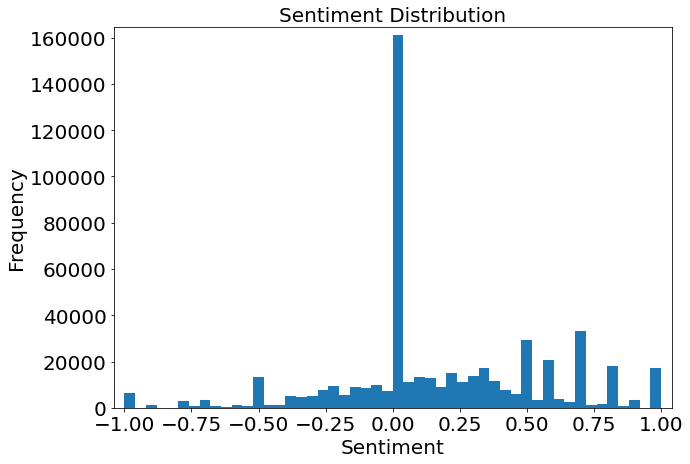

In [42]:
plt.figure(figsize=(10, 7))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.yticks(fontsize=20)
plt.hist(df['sentiment_stopwords'], bins=50)
plt.title('Sentiment Distribution', fontsize=20)
plt.show()

## Sentiment Analysis without stopwords

In [33]:
df['sentiment_without_stopwords'] = df['content_lemmatize_stopwords_remove'].apply(lambda x: TextBlob(x).sentiment.polarity)
df.head()

,reviewId,userImage,content,score,thumbsUpCount,at,content_words,content_sents,content_lemmatize,content_lemmatize_stopwords_remove,sentiment_stopwords,sentiment_without_stopwords
0,gp:AOqpTOE_kDnGh_ep3YzP9lvT1EXNZn149NKBZS6O7wbYF79d2gPcpDPoSYZcqMQJTsReBefzWA1YvMiyTfdqO9I,https://play-lh.googleusercontent.com/a-/AOh14GhCKkdKAOzTfsUaXbh6OQ8TSzIpha0ZdDP5yFBF,Love it,5,0,2022-03-26 22:34:58,"[Love, it]",[Love it],Love it,Love,0.500000,0.500000
1,gp:AOqpTOEsFX7k4uvzb9nMFhm3_F_fi8jO4XJRTDXaVTTwOuIPORaBOV5FD5vFawtgDNn0JYLkECTjKymG58YRp80,https://play-lh.googleusercontent.com/a/AATXAJwWCqtvQl5oXnmef_YcxWBmFbcArernRxvIfDxuiw=mo,"Very greedy app. I bought Tinder Platinum, but anyway have to pay a lot of other options",1,0,2022-03-26 22:31:32,"[Very, greedy, app, I, bought, Tinder, Platinum, but, anyway, have, to, pay, a, lot, of, other, ...","[Very greedy app., I bought Tinder Platinum, but anyway have to pay a lot of other options]",Very greedy app I bought Tinder Platinum but anyway have to pay a lot of other option,Very greedy app I bought Tinder Platinum anyway pay lot option,0.037500,0.200000
2,gp:AOqpTOFrbe5VHxNYs2DiAiQSBE1iRudXd0z1vB9U77TMObQM8drXxR0OHfzw0KzR1QZtB2Yo6GQQ48F-TZO7xtw,https://play-lh.googleusercontent.com/a-/AOh14Giq0fS5ZzqzG0QLM2MPR5aMSLUrXpMhpZk6qhQoGQ,"Met my girlfriend here, so gotta rate it 5/5",5,0,2022-03-26 22:06:54,"[Met, my, girlfriend, here, so, got, ta, rate, it, 55]","[Met my girlfriend here, so gotta rate it 5/5]",Met my girlfriend here so got ta rate it 55,Met girlfriend got ta rate 55,0.000000,0.000000
3,gp:AOqpTOFlSy_0E2l-R9A3ncMJF2RVTNgfk6i818PufiGIFlU-iaVmGeoLNinx6wvr9KJCua7PCXqP8iVputMi7YM,https://play-lh.googleusercontent.com/a/AATXAJwaWDms44vgvf9Kryr0B_aiUbEpf1dI7RETz6hb=mo,Adding profile pictures. Useless. How are they sorted? Can't find any personal photos taken. Use...,1,1,2022-03-26 21:59:56,"[Adding, profile, pictures, Useless, How, are, they, sorted, Cant, find, any, personal, photos, ...","[Adding profile pictures., Useless., How are they sorted?, Can't find any personal photos taken....",Adding profile picture Useless How are they sorted Cant find any personal photo taken Useless,Adding profile picture Useless How sorted Cant find personal photo taken Useless,-0.333333,-0.333333
4,gp:AOqpTOHc7vZRC2k4YEsHxfGNZsEWRieGIboc5CILynvWjW40MBMsMkH_ulDzr6PyrTRXNXHC_suZ_QZMj8aTqqQ,https://play-lh.googleusercontent.com/a/AATXAJxDb7xkW9_KZ7WFe1xLtaTgj_jAVegyswZySP-X=mo,"Its not working, im trying to sing up for tow days but nothhng work, sorry but that is the truth",1,0,2022-03-26 21:45:59,"[Its, not, working, im, trying, to, sing, up, for, tow, days, but, nothhng, work, sorry, but, th...","[Its not working, im trying to sing up for tow days but nothhng work, sorry but that is the truth]",Its not working im trying to sing up for tow day but nothhng work sorry but that is the truth,Its working im trying sing tow day nothhng work sorry truth,-0.500000,-0.500000


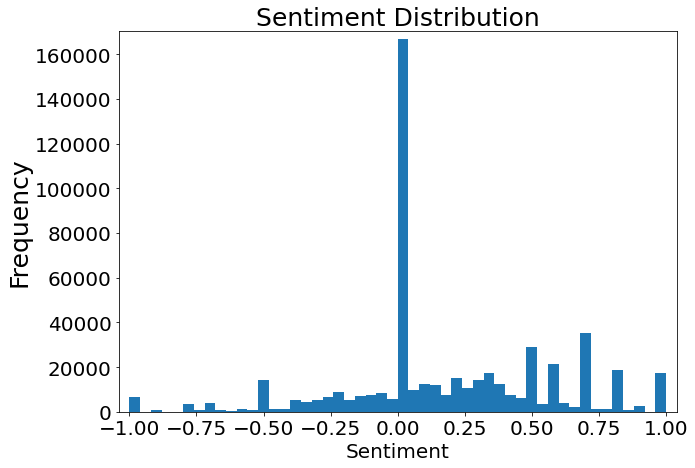

In [41]:
plt.figure(figsize=(10,7))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Frequency', fontsize=25)
plt.yticks(fontsize=20)
plt.hist(df['sentiment_without_stopwords'], bins=50)
plt.title('Sentiment Distribution', fontsize=25)
plt.show()

# Rating

C:\Users\sadpa\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

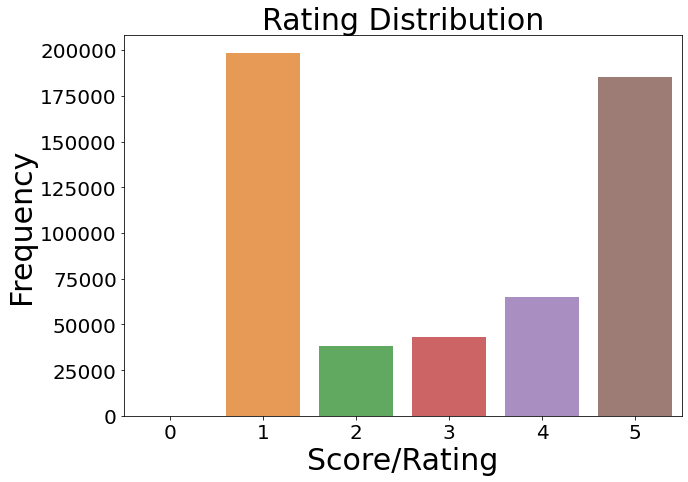

In [38]:
x_rating = df.score.value_counts()
y_rating = x_rating.sort_index()
plt.figure(figsize=(10,7))
sns.barplot(x_rating.index, x_rating.values, alpha=0.8)
plt.title("Rating Distribution", fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.yticks(fontsize=20)
plt.xlabel('Score/Rating', fontsize=30)
plt.xticks(fontsize=20)

<AxesSubplot:title={'center':'Percentage of Ratings/Score'}, ylabel='score'>

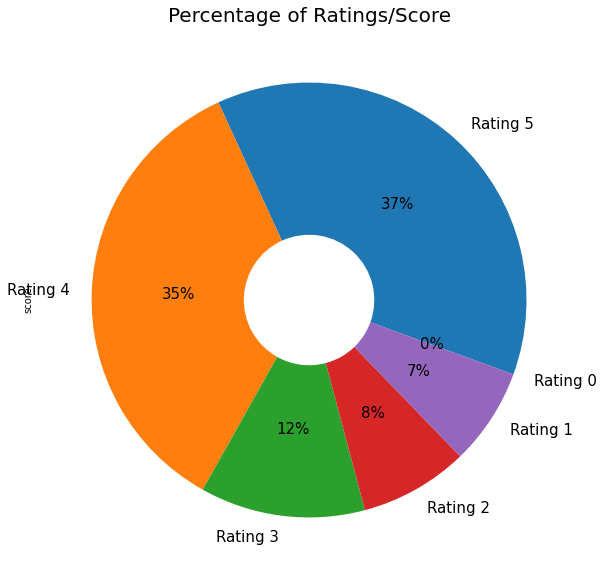

In [43]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Ratings/Score', fontsize=20)
df.score.value_counts().plot(kind='pie', labels=['Rating 5', 'Rating 4', 'Rating 3', 'Rating 2', 'Rating 1', 'Rating 0'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})

# Score and Sentiment

## Setiment stopwords and score comparison

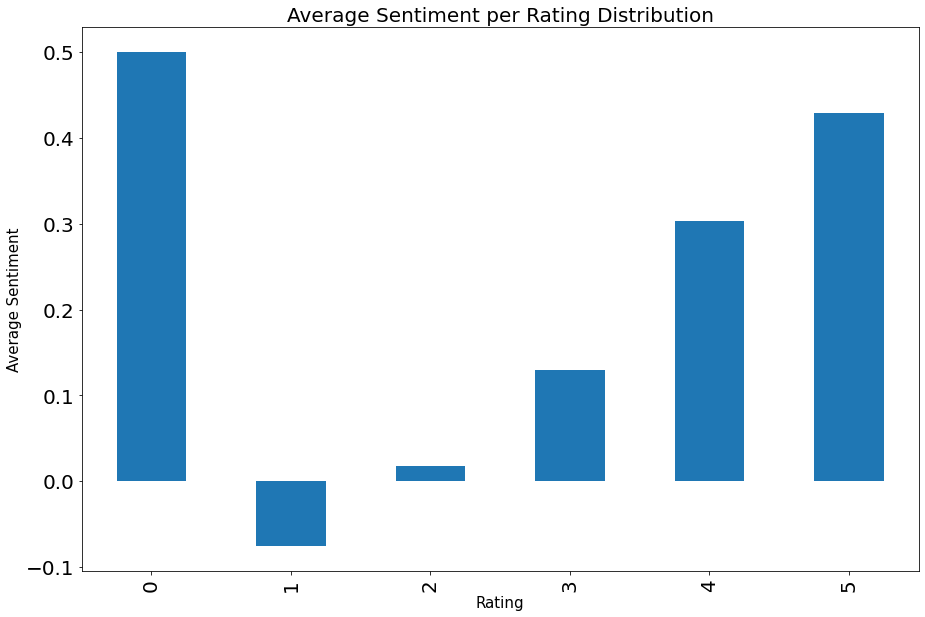

In [44]:
polarity_avg = df.groupby('score')['sentiment_stopwords'].mean().plot(kind='bar', figsize=(15,10))
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Average Sentiment per Rating Distribution', fontsize=20)
plt.show()

## Setiment without Stopwords and score comparison

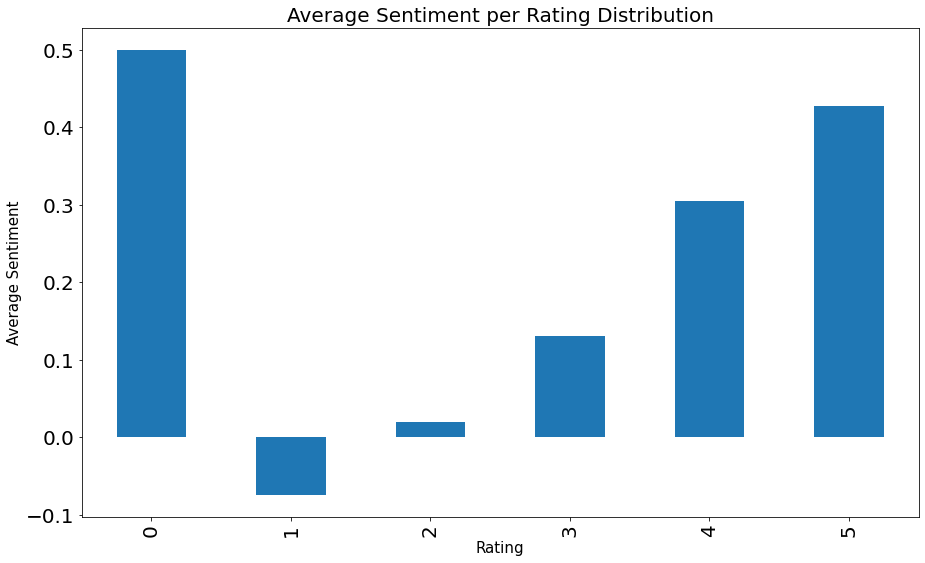

In [45]:
polarity_avg = df.groupby('score')['sentiment_without_stopwords'].mean().plot(kind='bar', figsize=(15,9))
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Average Sentiment per Rating Distribution', fontsize=20)
plt.show()

# Length Review and Score

In [46]:
df['word_count'] = df['content_lemmatize'].apply(lambda x: len(str(x).split()))
df['review_len'] = df['content_lemmatize'].astype(str).apply(len)

In [47]:
df.head(5)

,reviewId,userImage,content,score,thumbsUpCount,at,content_words,content_sents,content_lemmatize,content_lemmatize_stopwords_remove,sentiment_stopwords,sentiment_without_stopwords,word_count,review_len
0,gp:AOqpTOE_kDnGh_ep3YzP9lvT1EXNZn149NKBZS6O7wbYF79d2gPcpDPoSYZcqMQJTsReBefzWA1YvMiyTfdqO9I,https://play-lh.googleusercontent.com/a-/AOh14GhCKkdKAOzTfsUaXbh6OQ8TSzIpha0ZdDP5yFBF,Love it,5,0,2022-03-26 22:34:58,"[Love, it]",[Love it],Love it,Love,0.500000,0.500000,2,8
1,gp:AOqpTOEsFX7k4uvzb9nMFhm3_F_fi8jO4XJRTDXaVTTwOuIPORaBOV5FD5vFawtgDNn0JYLkECTjKymG58YRp80,https://play-lh.googleusercontent.com/a/AATXAJwWCqtvQl5oXnmef_YcxWBmFbcArernRxvIfDxuiw=mo,"Very greedy app. I bought Tinder Platinum, but anyway have to pay a lot of other options",1,0,2022-03-26 22:31:32,"[Very, greedy, app, I, bought, Tinder, Platinum, but, anyway, have, to, pay, a, lot, of, other, ...","[Very greedy app., I bought Tinder Platinum, but anyway have to pay a lot of other options]",Very greedy app I bought Tinder Platinum but anyway have to pay a lot of other option,Very greedy app I bought Tinder Platinum anyway pay lot option,0.037500,0.200000,17,86
2,gp:AOqpTOFrbe5VHxNYs2DiAiQSBE1iRudXd0z1vB9U77TMObQM8drXxR0OHfzw0KzR1QZtB2Yo6GQQ48F-TZO7xtw,https://play-lh.googleusercontent.com/a-/AOh14Giq0fS5ZzqzG0QLM2MPR5aMSLUrXpMhpZk6qhQoGQ,"Met my girlfriend here, so gotta rate it 5/5",5,0,2022-03-26 22:06:54,"[Met, my, girlfriend, here, so, got, ta, rate, it, 55]","[Met my girlfriend here, so gotta rate it 5/5]",Met my girlfriend here so got ta rate it 55,Met girlfriend got ta rate 55,0.000000,0.000000,10,44
3,gp:AOqpTOFlSy_0E2l-R9A3ncMJF2RVTNgfk6i818PufiGIFlU-iaVmGeoLNinx6wvr9KJCua7PCXqP8iVputMi7YM,https://play-lh.googleusercontent.com/a/AATXAJwaWDms44vgvf9Kryr0B_aiUbEpf1dI7RETz6hb=mo,Adding profile pictures. Useless. How are they sorted? Can't find any personal photos taken. Use...,1,1,2022-03-26 21:59:56,"[Adding, profile, pictures, Useless, How, are, they, sorted, Cant, find, any, personal, photos, ...","[Adding profile pictures., Useless., How are they sorted?, Can't find any personal photos taken....",Adding profile picture Useless How are they sorted Cant find any personal photo taken Useless,Adding profile picture Useless How sorted Cant find personal photo taken Useless,-0.333333,-0.333333,15,94
4,gp:AOqpTOHc7vZRC2k4YEsHxfGNZsEWRieGIboc5CILynvWjW40MBMsMkH_ulDzr6PyrTRXNXHC_suZ_QZMj8aTqqQ,https://play-lh.googleusercontent.com/a/AATXAJxDb7xkW9_KZ7WFe1xLtaTgj_jAVegyswZySP-X=mo,"Its not working, im trying to sing up for tow days but nothhng work, sorry but that is the truth",1,0,2022-03-26 21:45:59,"[Its, not, working, im, trying, to, sing, up, for, tow, days, but, nothhng, work, sorry, but, th...","[Its not working, im trying to sing up for tow days but nothhng work, sorry but that is the truth]",Its not working im trying to sing up for tow day but nothhng work sorry but that is the truth,Its working im trying sing tow day nothhng work sorry truth,-0.500000,-0.500000,20,94


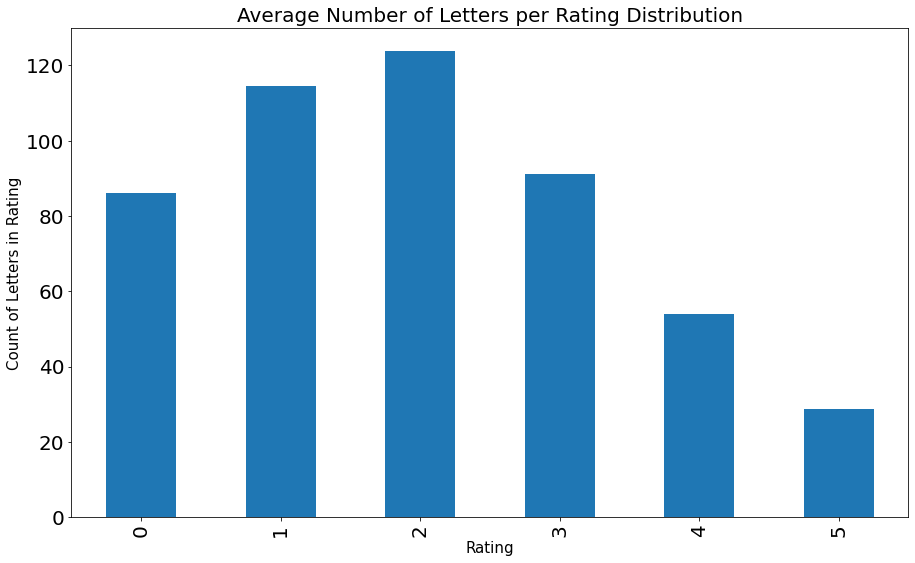

In [48]:
letter_avg = df.groupby('score')['review_len'].mean().plot(kind='bar', figsize=(15, 9))
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Count of Letters in Rating', fontsize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Average Number of Letters per Rating Distribution', fontsize=20)
plt.show()

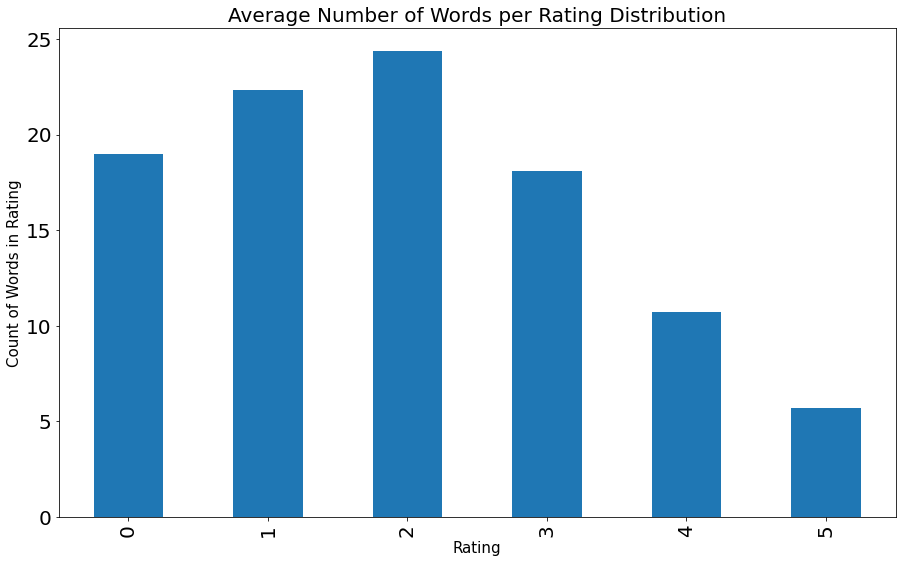

In [49]:
word_avg = df.groupby('score')['word_count'].mean().plot(kind='bar', figsize=(15, 9))
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Count of Words in Rating', fontsize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Average Number of Words per Rating Distribution', fontsize=20)
plt.show()

C:\Users\sadpa\AppData\Local\Temp\ipykernel_8892\2661189697.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlation, dtype=np.bool)


<AxesSubplot:>

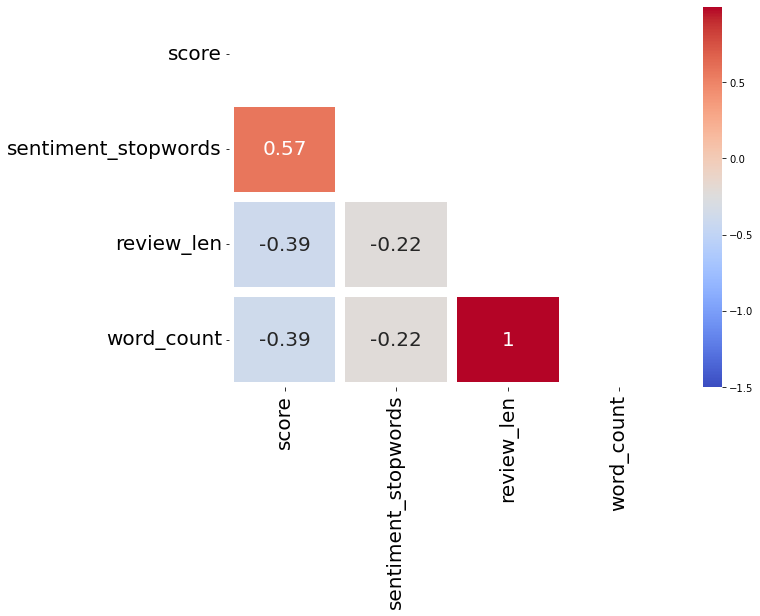

In [51]:
correlation = df[['score','sentiment_stopwords', 'review_len', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,7))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 20}, linewidths=10, vmin=-1.5, mask=mask)

# WordCloud

In [52]:
words = df['content_words']
allwords = []
for wordlist in words:
    allwords += wordlist

In [53]:
new_words = []
for word in allwords:
    if word not in stop_words:
        new_words.append(word)

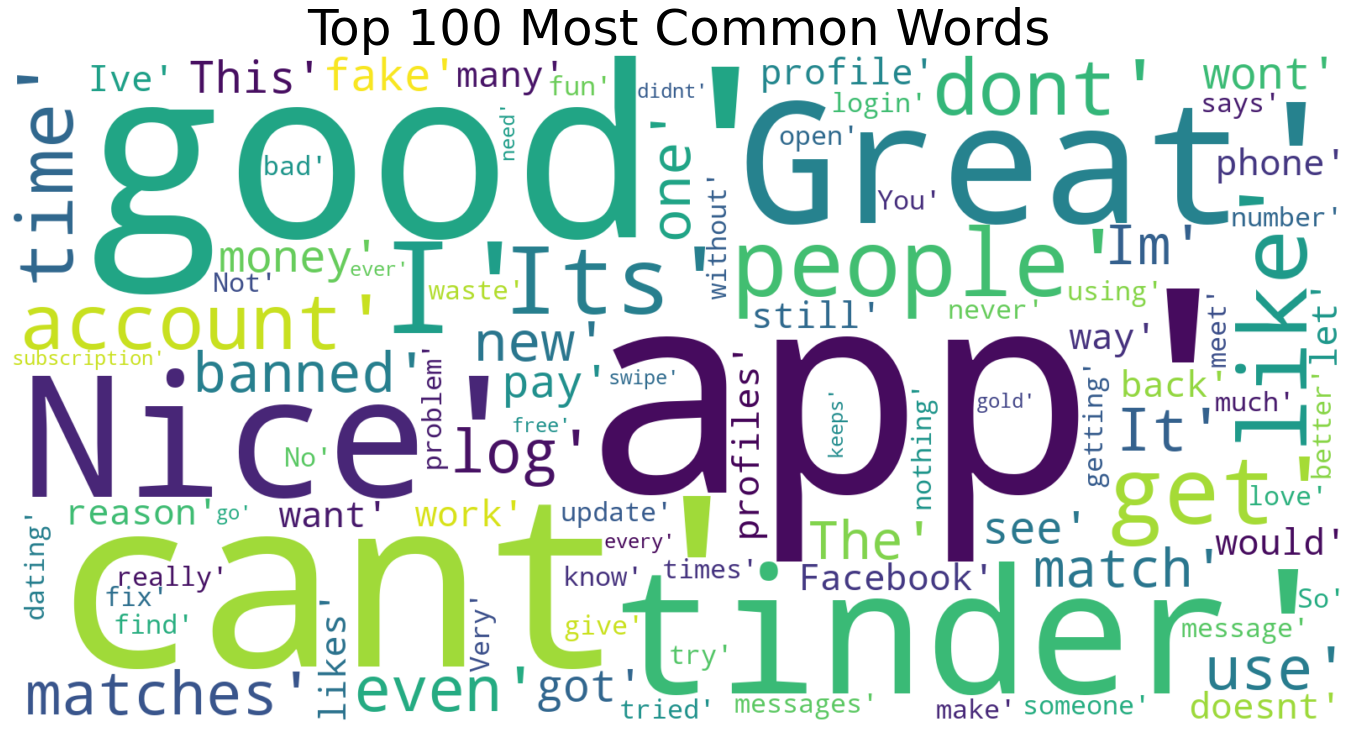

In [54]:
mostcommon = FreqDist(new_words).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(20,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

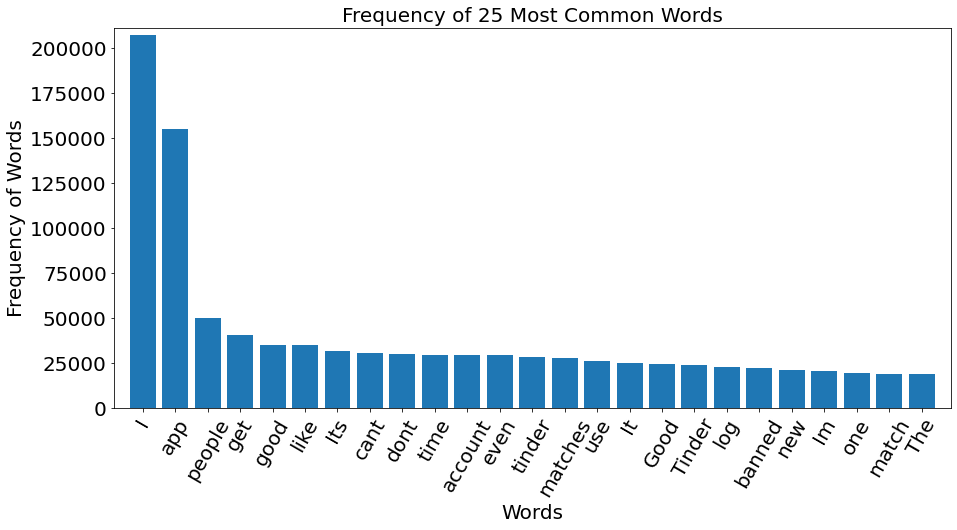

In [56]:
mostcommon_small = FreqDist(new_words).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(15, 7))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency of Words', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=60, fontsize=20)
plt.title('Frequency of 25 Most Common Words', fontsize=20)
plt.show()